In [1]:
import scipy.special
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from pathlib import Path
from torch import nn
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import RandEdgeSampler, get_neighbor_finder
from model.tgn import TGN
from scipy.optimize import minimize
from sklearn import metrics

## Choice of the dataset

In [2]:
dataset_train = "Synthetic"
dataset = dataset_train

## Reliability scores computation

In [3]:
def my_loss(output):
    return 1-output

# On charge TGN sur les données d'entraînement
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(dataset_train)
    
full_ngh_finder = get_neighbor_finder(full_data, False)
    
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

NUM_LAYER = 1
NUM_HEADS = 2
DROP_OUT = 0.1
USE_MEMORY = True
MESSAGE_DIM = 100
MEMORY_DIM = 172
NUM_NEIGHBORS = 10
    
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/tgn-attn-{dataset_train}.pth', map_location=torch.device('cpu')))

# On charge les charge
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(dataset)

full_ngh_finder = get_neighbor_finder(full_data, False)

mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

# On adapte le modèle au nouveau nombre de noeuds
model.memory.memory = nn.Parameter(torch.zeros((full_data.n_unique_nodes+1,MEMORY_DIM)))
model.memory.last_update = nn.Parameter(torch.zeros(full_data.n_unique_nodes+1))
torch.save(model.state_dict(), 'saved_models/test.pth')
    
# On charge le modèle adapté
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
        edge_features=edge_features, device='cpu',
        n_layers=NUM_LAYER,
        n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
        message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
        memory_update_at_start= True,
        embedding_module_type='graph_attention',
        message_function='identity',
        aggregator_type='last',
        memory_updater_type='gru',
        n_neighbors=NUM_NEIGHBORS,
        mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
        mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
        use_destination_embedding_in_message=False,
        use_source_embedding_in_message=False,
        dyrep=False)
model.load_state_dict(torch.load(f'saved_models/test.pth'))
model.eval()
    
# On avance la mémoire jusqu'à (au batch de) l'interaction choisie
model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))
    
TEST_BATCH_SIZE = 1
num_test_instance = len(full_data.sources)
num_test_batch = math.ceil(num_test_instance / TEST_BATCH_SIZE)

for p in model.parameters():
    p.requires_grad = False

node_confidence = np.empty((model.n_nodes,),dtype=object)
colors2confidence = np.empty((model.n_nodes,),dtype=object)
for i in range(len(node_confidence)):
    node_confidence[i] = []
    colors2confidence[i] = []
interaction_confidence = np.zeros(num_test_instance)
anom_score = np.zeros(num_test_instance)
grad_src = []
grad_dst = []
for k in range(num_test_batch):
    loss = 0
    
    s_idx = k * TEST_BATCH_SIZE
    e_idx = min(num_test_instance, s_idx + TEST_BATCH_SIZE)
    
    sources_batch = full_data.sources[s_idx:e_idx]
    destinations_batch = full_data.destinations[s_idx:e_idx]
    timestamps_batch = full_data.timestamps[s_idx:e_idx]
    edge_idxs_batch = full_data.edge_idxs[s_idx: e_idx]
        
    size = len(sources_batch)
    
    ## On charge tous les vecteurs par rapport auxquels on souhaite différencier
    
    memory, _ = model.get_updated_memory(list(range(model.n_nodes)),
                                                      model.memory.messages)
    
        #  Src attributes and memory
    
    source_nodes_features = model.node_raw_features[sources_batch, :]
    source_nodes_memory = memory[sources_batch, :]
    
        # Dst attributes and memory
    
    destination_nodes_features = model.node_raw_features[destinations_batch, :]
    destination_nodes_memory = memory[destinations_batch, :]
    
        #  Neighbors attributes and memory + edge attributes
        
    all_nodes = np.concatenate([sources_batch, destinations_batch, destinations_batch])
    timestamps = np.concatenate([timestamps_batch, timestamps_batch, timestamps_batch])
    
    neighbors, edge_idxs, edge_times = model.neighbor_finder.get_temporal_neighbor(
        all_nodes,
        timestamps,
        n_neighbors=10)

    neigh_features = model.node_raw_features[neighbors, :]
    neigh_memory = memory[neighbors, :]

    e_features = model.edge_raw_features[edge_idxs, :]
    
        # Gradient w.r.t. these quantities
    
    source_nodes_features.requires_grad = True
    source_nodes_memory.requires_grad = True
    destination_nodes_features.requires_grad = True
    destination_nodes_memory.requires_grad = True
    neigh_features.requires_grad = True
    neigh_memory.requires_grad = True
    e_features.requires_grad = True
    
    pos_prob, neg_prob = model.compute_edge_probabilities_grad(sources_batch, destinations_batch,
                                                        destinations_batch, timestamps_batch, edge_idxs_batch,
                                                        source_nodes_features, source_nodes_memory,
                                                        destination_nodes_features, destination_nodes_memory,
                                                        neigh_features, neigh_memory, e_features, NUM_NEIGHBORS)


    loss = my_loss(pos_prob.squeeze())
    loss.backward()

    src_confidence = 2*np.linalg.norm(source_nodes_memory.grad.detach().numpy(), axis = 1)[0] + 2*np.linalg.norm(neigh_features.grad.detach().numpy()[0]) + np.linalg.norm(e_features.grad.detach().numpy()[0])
    dst_confidence = 2*np.linalg.norm(destination_nodes_memory.grad.detach().numpy(), axis = 1)[0] + 2*np.linalg.norm(neigh_memory.grad.detach().numpy()[1]) + np.linalg.norm(e_features.grad.detach().numpy()[1])
    node_confidence[sources_batch[0]].append(src_confidence)
    node_confidence[destinations_batch[0]].append(dst_confidence)
    colors2confidence[sources_batch[0]].append('b')
    colors2confidence[destinations_batch[0]].append('r')
    interaction_confidence[k] = node_confidence[sources_batch[0]][-1]+node_confidence[destinations_batch[0]][-1]
    anom_score[k] = 1-pos_prob
    if k%100 == 0:
        print(k, '/', len(full_data.sources))
    source_nodes_features.requires_grad = False
    source_nodes_memory.requires_grad = False
    destination_nodes_features.requires_grad = False
    destination_nodes_memory.requires_grad = False
    neigh_features.requires_grad = False
    neigh_memory.requires_grad = False
    e_features.requires_grad = False
    loss = 0

(2001, 172)
The dataset has 21324 interactions, involving 2000 different nodes
The training dataset has 12097 interactions, involving 1791 different nodes
The validation dataset has 3198 interactions, involving 1656 different nodes
The test dataset has 3199 interactions, involving 1639 different nodes
The new node validation dataset has 614 interactions, involving 654 different nodes
The new node test dataset has 645 interactions, involving 653 different nodes
200 nodes were used for the inductive testing, i.e. are never seen during training
(2001, 172)
The dataset has 21324 interactions, involving 2000 different nodes
The training dataset has 12097 interactions, involving 1791 different nodes
The validation dataset has 3198 interactions, involving 1656 different nodes
The test dataset has 3199 interactions, involving 1639 different nodes
The new node validation dataset has 614 interactions, involving 654 different nodes
The new node test dataset has 645 interactions, involving 653 dif

In [4]:
if Path(f'./data/anom_edges/{dataset}_anom_edges.csv').is_file():
    anom_edges = pd.read_csv(f'./data/anom_edges/{dataset}_anom_edges.csv').to_numpy().T[0]

reliability_score = 1 - interaction_confidence/max(interaction_confidence)

## Results

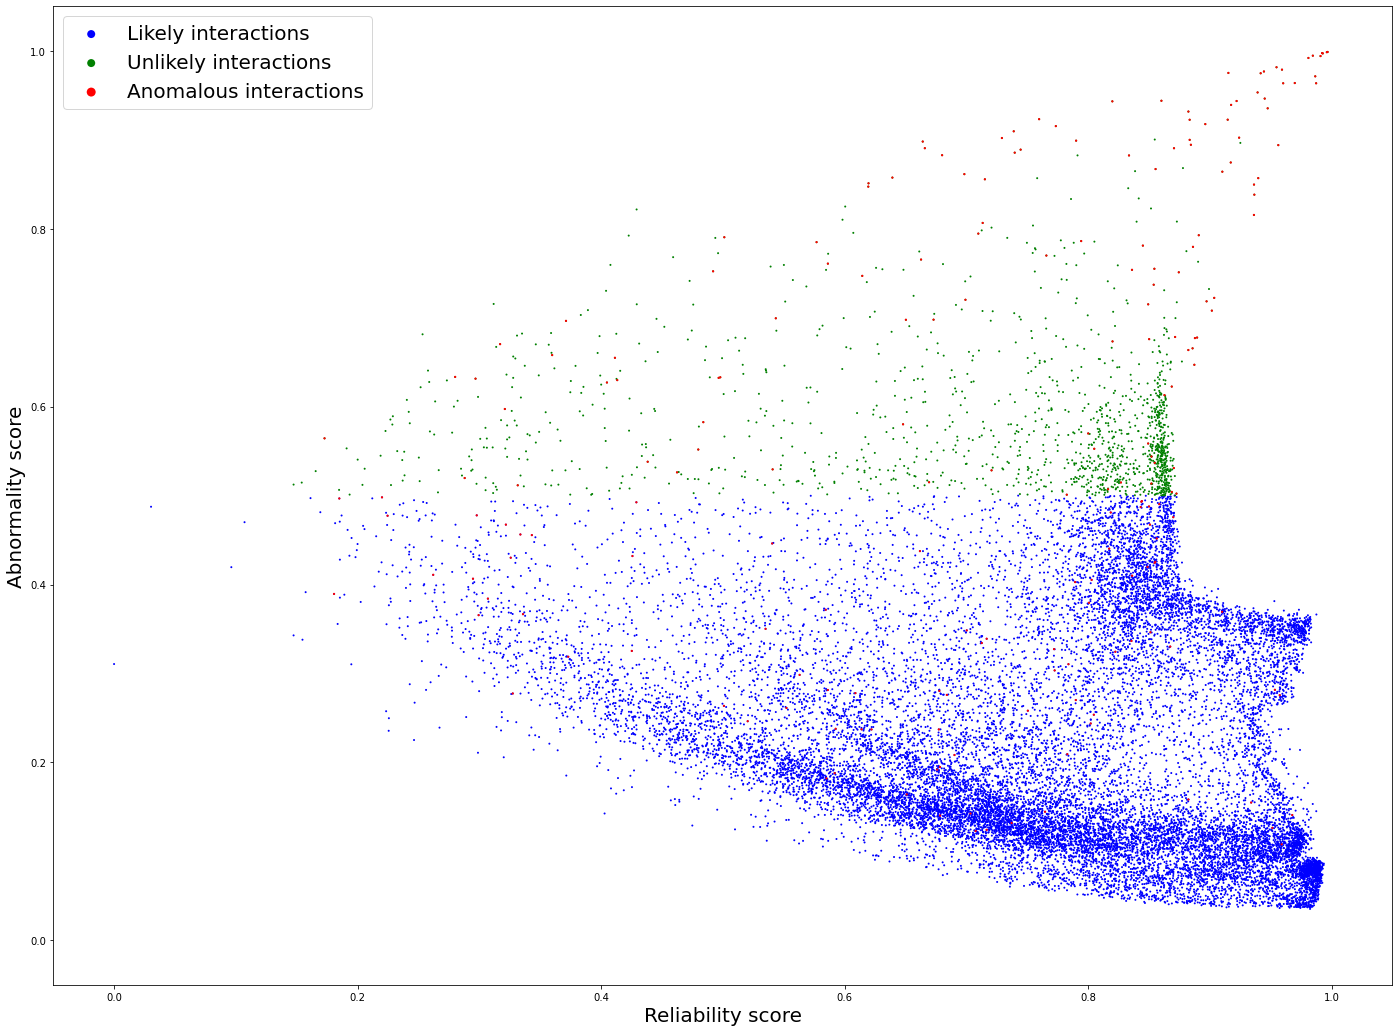

In [5]:
colors = []
for i in range(len(anom_score)):
    colors.append('b')
for interaction in np.where(anom_score<=0.5)[0]:
    colors[interaction] = 'g'
for interaction in anom_edges:
    colors[interaction] = 'r'
    
if Path(f'./data/snaps/{dataset}_snaps.csv').is_file():
    snaps_indices = pd.read_csv(f'./data/snaps/{dataset}_snaps.csv').to_numpy().T[0]
else:
    snaps_indices = np.array([0, len(full_data.sources)])
    
snap = snaps_indices[0]

fig, ax = plt.subplots(figsize=(24,18))
ax.scatter(reliability_score[snap:][np.where(anom_score[snap:]<=0.5)[0]],
           anom_score[snap:][np.where(anom_score[snap:]<=0.5)[0]], c='b', s=4, label='Likely interactions', edgecolors='none')
ax.scatter(reliability_score[snap:][np.where(anom_score[snap:]>0.5)[0]],
           anom_score[snap:][np.where(anom_score[snap:]>0.5)[0]], c='g', s=4, label="Unlikely interactions", edgecolors='none')
ax.scatter(reliability_score[anom_edges],
           anom_score[anom_edges], c='r', s=5, label="Anomalous interactions", edgecolors='none')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.legend(markerscale=4,prop=dict(size=20))

ax.set_xlabel('Reliability score', fontsize = 20)
ax.set_ylabel('Abnormality score', fontsize = 20)
plt.show()